# VSB Powerline baseline

using spectrograms created in vsb_powerline_spectrograms

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [3]:
from fastai.vision import *

In [4]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [5]:
import fastai
print(fastai.__version__)

1.0.39.dev0


In [6]:
torch.cuda.set_device(0)

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [8]:
DATE

'20181228'

In [9]:
UID

'42b45a36'

In [10]:
image_size=300
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [11]:
path = Path('../input/')
train_path = path/'train/'

In [12]:
test_path = path/'test/'

In [13]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [14]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [15]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


### Image Data

In [16]:
tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0.05, max_warp=0, p_lighting=0.1, xtra_tfms=[jitter(magnitude=.0001)])

In [17]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

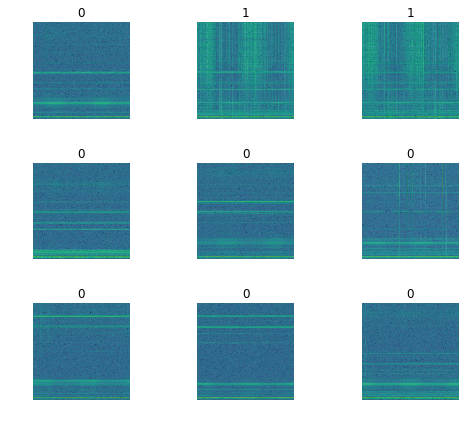

In [18]:
data.show_batch(rows=3, figsize=(7,6))

In [19]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

## Training: resnet34

In [20]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [21]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,0.409498,0.152631,0.046498
2,0.179469,0.132346,0.048794
3,0.113872,0.126488,0.044202
4,0.078468,0.121490,0.043628
5,0.056602,0.118842,0.043054


In [22]:
learn.save('baseline_stage-1')

## Results

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

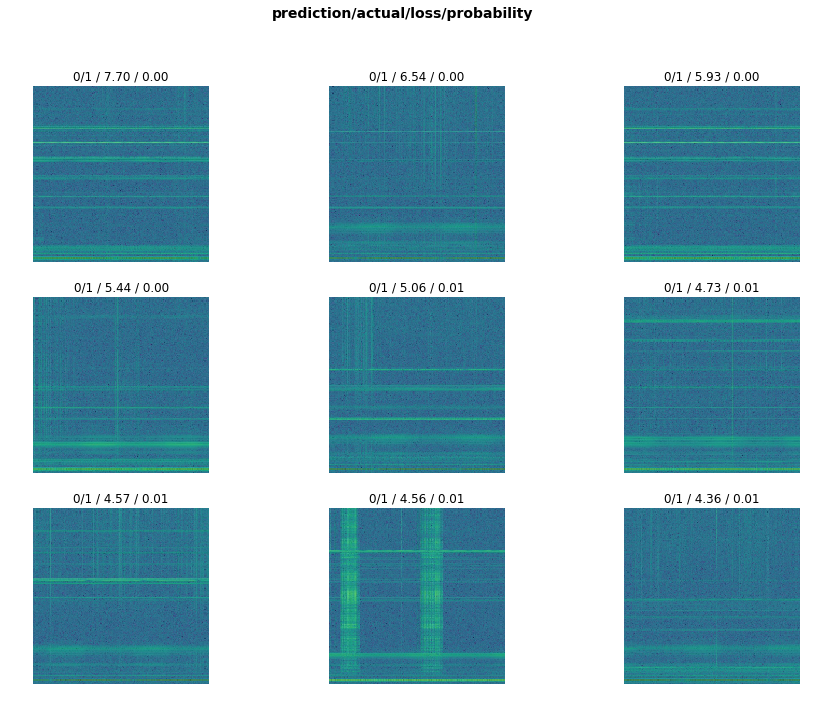

In [24]:
interp.plot_top_losses(9, figsize=(15,11))

In [25]:
doc(interp.plot_top_losses)

plot_top_losses [source] plot_top_losses ( k , largest = True , figsize = (12, 12) ) 
 
 Show images in top_losses along with their prediction, actual, loss, and probability of predicted class. 
 Show in docs

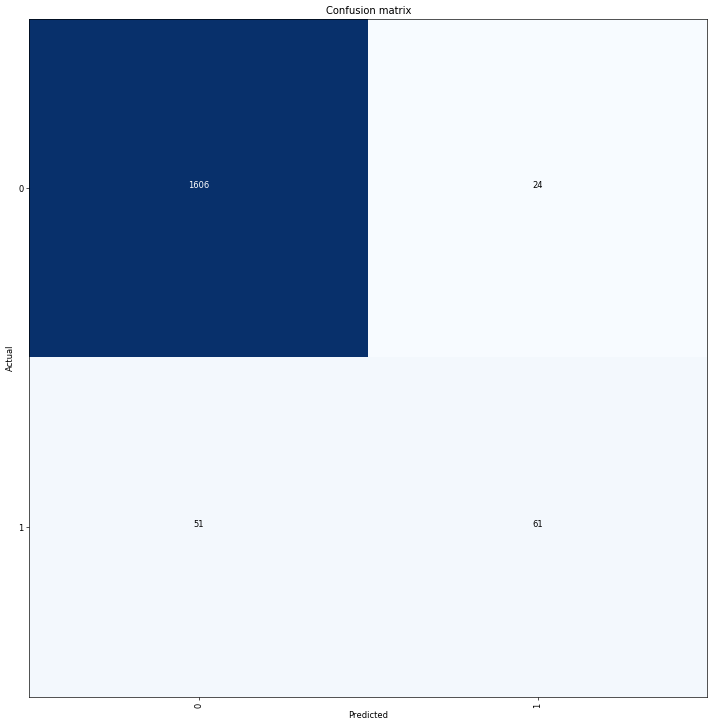

In [26]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
interp.most_confused(min_val=2)

[(1, 0, 51), (0, 1, 24)]

## Unfreezing, fine-tuning, and learning rates

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.125960,0.105721,0.044202


In [30]:
learn.load('baseline_stage-1');

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


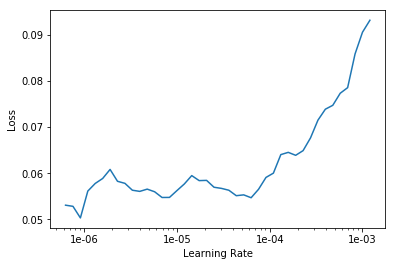

In [32]:
learn.recorder.plot()

In [33]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,2e-5))

epoch,train_loss,valid_loss,error_rate
1,0.047887,0.118397,0.041906
2,0.041887,0.118668,0.039610
3,0.035339,0.118159,0.040758
4,0.024950,0.121463,0.037313
5,0.021696,0.119201,0.038462


In [34]:
learn.save('baseline_stage-2_unfeeze')

### 1x1 prediction

In [35]:
#test_images = [f for f in listdir(test_path) if isfile(join(test_path, f))]

In [33]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [37]:
len(test_images)

20337

In [38]:
assert 20337 == len(test_images)

In [39]:
img = open_image(test_images[0])
type(img)

fastai.vision.image.Image

In [40]:
cat, val, probs=learn.predict(img)

In [41]:
cat.__str__()

'0'

In [42]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [43]:
df_sub=pd.DataFrame.from_dict(d, orient='index')

In [44]:
df_sub=df_sub.reset_index()
df_sub.head()

,index,0
0,28678,0
1,24274,0
2,24224,0
3,12637,0
4,23610,0


In [45]:
df_sub.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)

In [46]:
df_sub.head()

,signal_id,target
0,28678,0
1,24274,0
2,24224,0
3,12637,0
4,23610,0


In [47]:
len(df_sub)

20337

In [48]:
df_sub.to_csv(path/f'submissions/submission_baseline_stage-2_unfeeze_{DATE}_{UID}.csv', index=False)

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [23]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg', bs=4)
#data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
#                                   size=image_size, bs=bs//2).normalize(imagenet_stats)

In [24]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


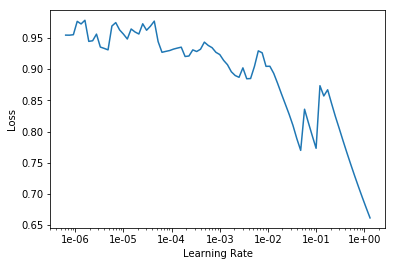

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(8, lrs)

epoch,train_loss,valid_loss,error_rate
1,0.147808,0.149485,0.047646
2,0.139324,0.133991,0.052813
3,0.157857,0.112974,0.043628
4,0.081695,0.117103,0.039610
5,0.176238,0.111274,0.042480
6,0.072990,0.114697,0.040758
7,0.108563,0.104782,0.036739
8,0.092015,0.103910,0.037313


In [ ]:
#learn.fit_one_cycle(8)

In [27]:
learn.save('baseline_stage-1-50')

In [28]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.165824,0.125582,0.048220
2,0.090475,0.129209,0.047072
3,0.114320,0.103357,0.039610


In [29]:
learn.save('baseline_stage-2-50')

In [30]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.176838,0.123343,0.055109
2,0.109677,0.108664,0.039610
3,0.047057,0.091301,0.039610


In [31]:
learn.save('baseline_stage-2-2-50')

In [ ]:
#learn.load('baseline_stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

In [ ]:
### Predict

In [34]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [35]:
df_sub_50_u=pd.DataFrame.from_dict(d, orient='index')

In [36]:
df_sub_50_u=df_sub_50_u.reset_index()


In [37]:
df_sub_50_u.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)
df_sub_50_u.head()

,signal_id,target
0,28678,0
1,24274,0
2,24224,0
3,12637,0
4,23610,0


In [38]:
df_sub_50_u.to_csv(path/f'submissions/submission_baseline_resnet-50_unfeeze-2-2_{DATE}_{UID}.csv', index=False)